# Multi-Class Dog Breed Classification

* The evaluation is a file with prediction probabilities for each dog breed of each test image.

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

2024-07-30 11:43:02.665527: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 11:43:02.665629: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 11:43:02.774041: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#Check for GPU
if tf.config.list_physical_devices("GPU"):
    print("Yes")
else:
    print("No")

Yes


## Getting data ready
Turning Images into numerical representations (Tensors).

In [3]:
import pandas as pd
import numpy as np
labels_csv=pd.read_csv("/kaggle/input/dog-breed-identification/labels.csv")

In [4]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [5]:
labels_csv.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126

<Axes: xlabel='breed'>

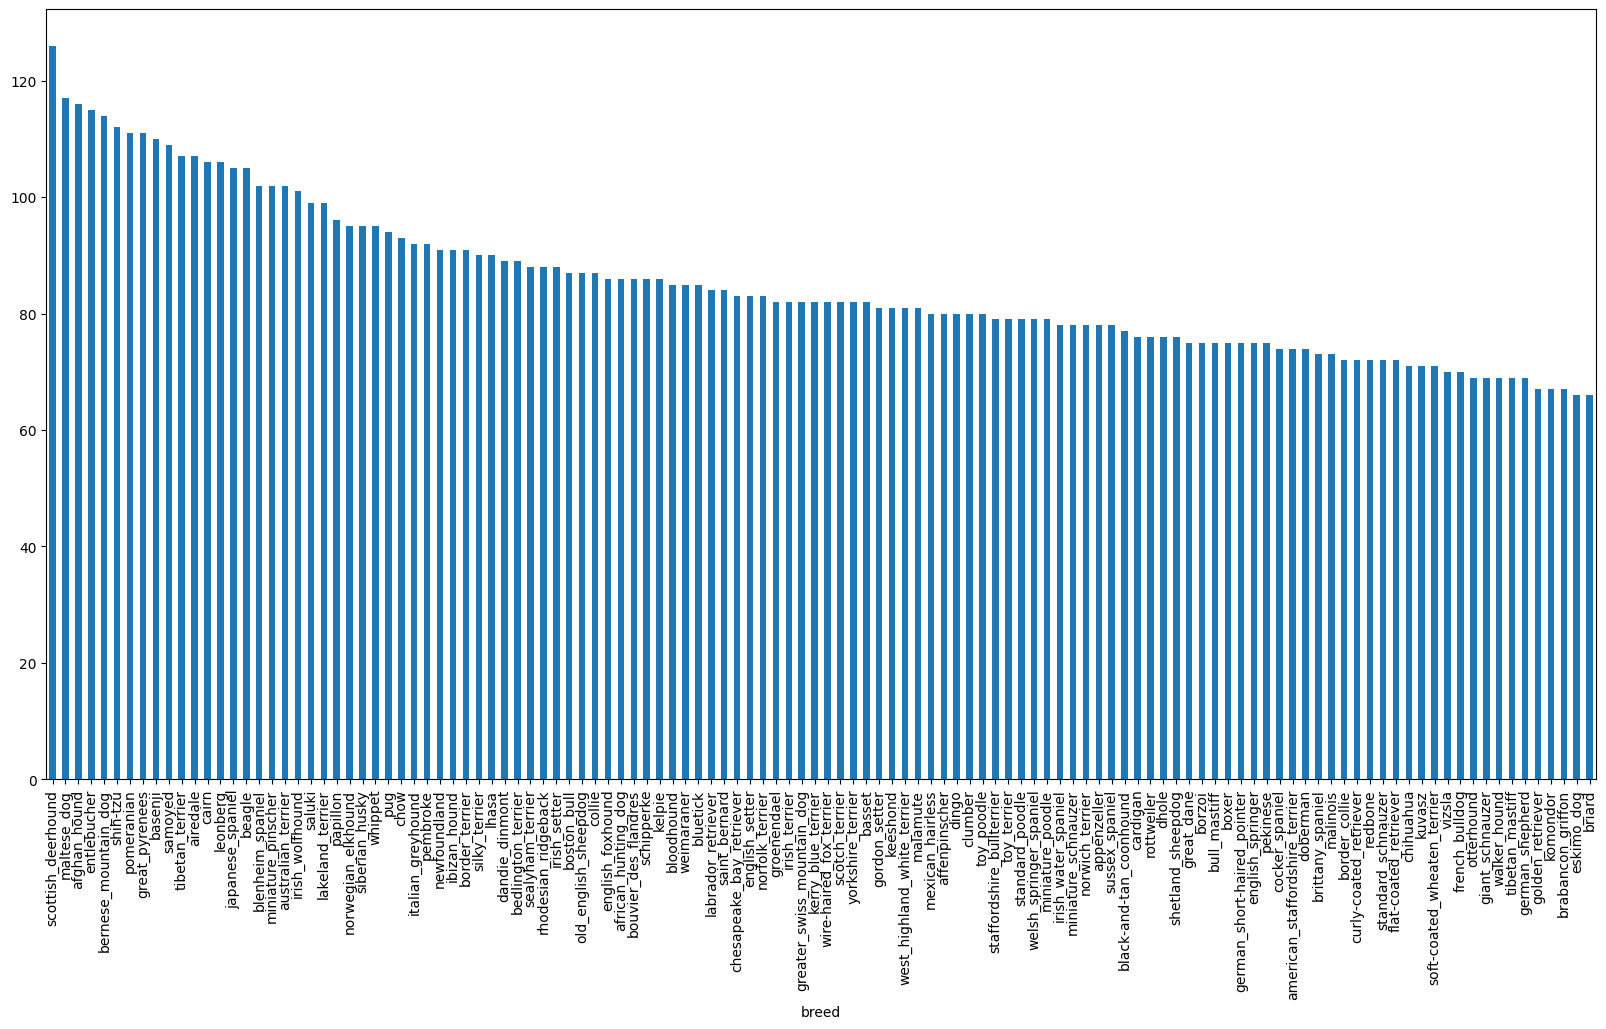

In [6]:
labels_csv["breed"].value_counts().plot(kind="bar",figsize=(20,10))

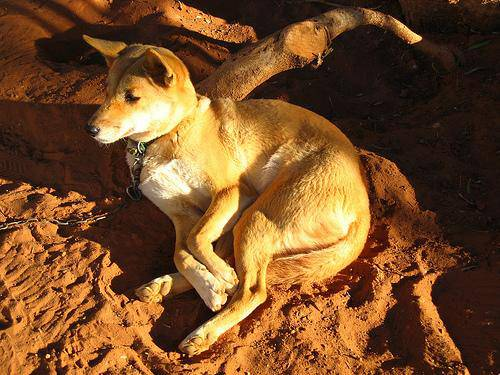

In [7]:
from IPython.display import Image
Image("/kaggle/input/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

## Getting Images and their Labels

In [8]:
filename=["/kaggle/input/dog-breed-identification/train/"+fname+".jpg" for fname in labels_csv["id"]]
filename[:10]

['/kaggle/input/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/kaggle/input/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/kaggle/input/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/kaggle/input/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/kaggle/input/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/kaggle/input/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/kaggle/input/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/kaggle/input/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/kaggle/input/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/kaggle/input/dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [9]:
labels=np.array(labels_csv["breed"])
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [10]:
unique_breeds=np.unique(labels)
len(unique_breeds)

120

In [11]:
boolean_labels=[label==unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [12]:
# Example: Turning a boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])[0][0]) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
19
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [13]:
x=filename
y=boolean_labels

In [14]:
# we're going to start off by experimenting with ~1000 images.
NUM_IMAGES=1000 

In [15]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x[:NUM_IMAGES],y[:NUM_IMAGES],test_size=0.2,random_state=42)
len(x_train),len(x_val),len(y_train),len(y_val)

(800, 200, 800, 200)

## Preprocessing Images (Turning Images to Tensors)
1. Takes an image filename as input.
2. Uses TensorFlow to read the file and save it to a variable, image.
3. Turn our image (a jpeg file) into Tensors.
4. Normalise the image, Convert the colour channel values from 0-225 values to 0-1 values
5. Resize the image to be of shape (224, 224).
6. Return the modified image.

In [16]:
from matplotlib.pyplot import imread
image=imread(filename[45])
image.shape

(375, 500, 3)

* Turn image into a Tensor

In [17]:
tf.constant(image)

<tf.Tensor: shape=(375, 500, 3), dtype=uint8, numpy=
array([[[85, 66, 60],
        [86, 67, 61],
        [84, 65, 59],
        ...,
        [41, 26, 23],
        [48, 33, 30],
        [51, 36, 33]],

       [[85, 66, 60],
        [89, 70, 64],
        [88, 69, 63],
        ...,
        [51, 36, 33],
        [58, 43, 40],
        [61, 46, 43]],

       [[90, 71, 65],
        [96, 77, 71],
        [96, 77, 71],
        ...,
        [59, 44, 41],
        [66, 51, 48],
        [70, 55, 52]],

       ...,

       [[45, 28, 20],
        [48, 31, 23],
        [47, 30, 22],
        ...,
        [54, 40, 31],
        [54, 40, 31],
        [54, 40, 31]],

       [[42, 25, 17],
        [45, 28, 20],
        [46, 29, 21],
        ...,
        [55, 41, 32],
        [55, 41, 32],
        [55, 41, 32]],

       [[38, 21, 13],
        [43, 26, 18],
        [45, 28, 20],
        ...,
        [57, 43, 34],
        [57, 43, 34],
        [57, 43, 34]]], dtype=uint8)>

In [18]:
IMG_SIZE=224
def process_image(image_path, image_size=IMG_SIZE):
    """
    Takes an image file path and turns it into a Tensor.
    """
    # Read in image file
    image=tf.io.read_file(image_path)
    # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
    image=tf.image.decode_jpeg(image,channels=3)
    # Convert the colour channel values from 0-225 values to 0-1 values
    image=tf.image.convert_image_dtype(image,tf.float32)
    # Resize the image to our desired size (224, 244)
    image=tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])
    return image

## Turning our data into batches
* All 10,000 images might not fit into the memory, hence we will use batch size of 32
* We need data in the form of Tensor tuples in the form (image, label)

In [19]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
    """
    Takes an image file path name and the associated label,
    processes the image and returns a tuple of (image, label).
    """
    image=process_image(image_path)
    return image, label

In [20]:
BATCH_SIZE=32
def create_data_batches(x,y=None,valid_data=False,test_data=False):
    """
    Creates batches of data out of image (x) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
    Also accepts test data as input (no labels).
    """
    #Test data doesn't have labels
    if test_data:
        print("Creating Test Batches")
        data =tf.data.Dataset.from_tensor_slices((tf.constant(x)))
        data_batch=data.map(process_image).batch(BATCH_SIZE)
        return data_batch
    #Validation data has labels                 
    elif valid_data:
        print("Creating Validation Batch")
        data=tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
        data_batch=data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
    else:
    #This will be the training data so we will have to shuffle the data
        print("Creating Training Batch")
        data=tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
        #Shuffle pathnames and labels as it is faster than shuffling images
        data=data.shuffle(buffer_size=len(x))
        data=data.map(get_image_label)
        data_batch=data.batch(BATCH_SIZE)
        return data_batch

In [21]:
train_data=create_data_batches(x_train,y_train)
val_data=create_data_batches(x_val,y_val,valid_data=True)

Creating Training Batch
Creating Validation Batch


In [22]:
#Different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Vizualizing Data

In [23]:
import matplotlib.pyplot as plt
#create a function for viewing images in a data_batch
def show_image(images,labels):
    plt.figure(figsize=(15,15))
    for i in range(0,25):
        ax=plt.subplot(5,5,i+1)
        plt.imshow(images[i])
        plt.title(unique_breeds[labels[i].argmax()])
        plt.axis("off")

In [24]:
train_images,train_labels=next(train_data.as_numpy_iterator())

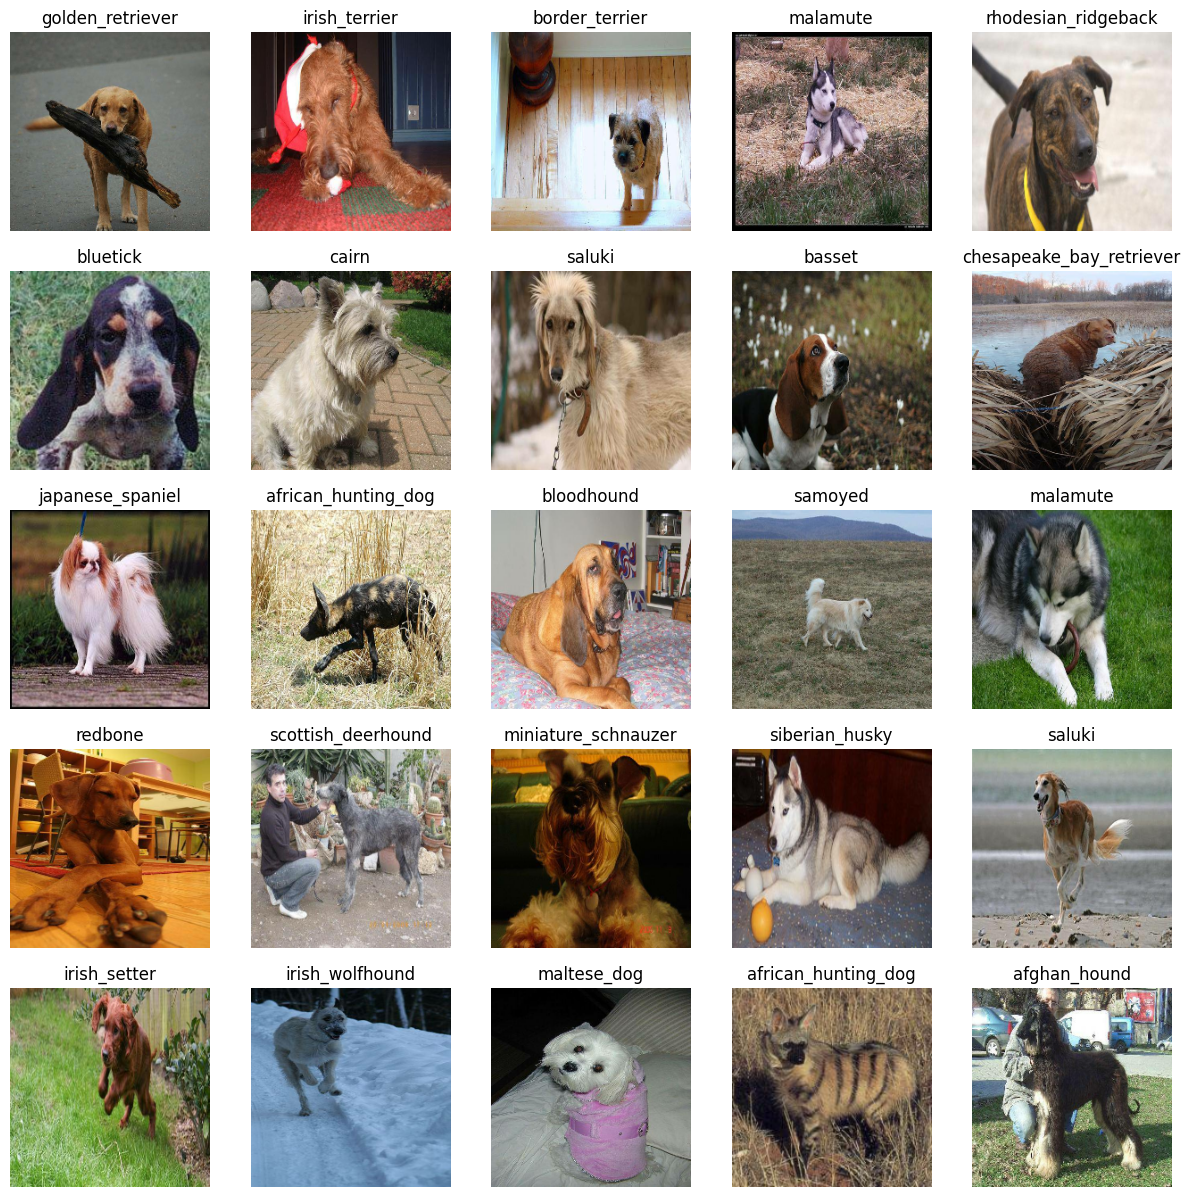

In [25]:
show_image(train_images,train_labels)

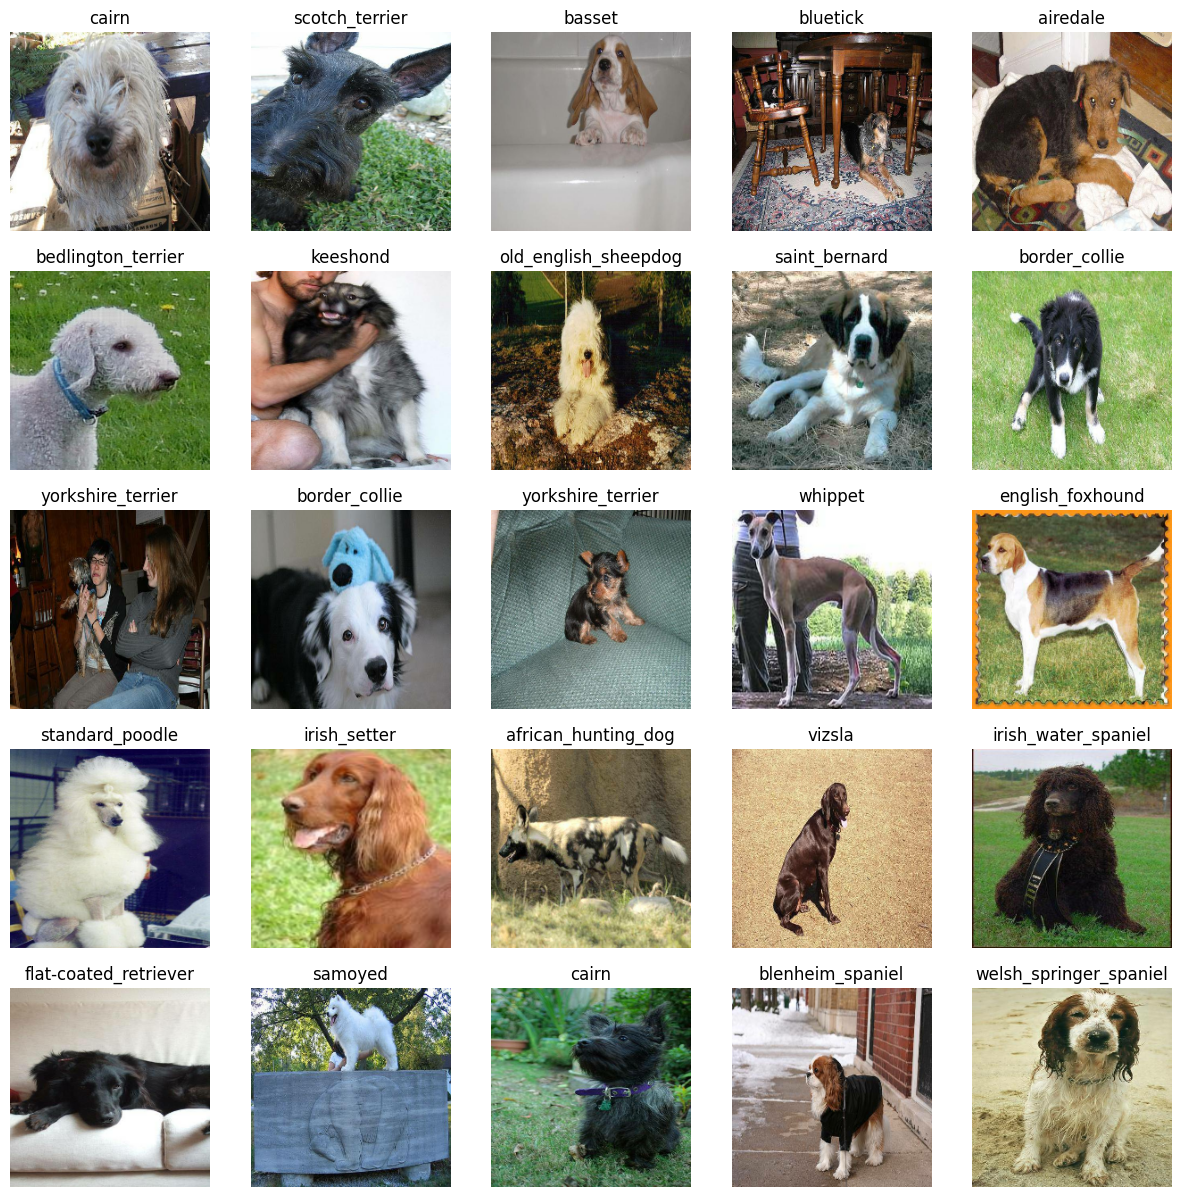

In [26]:
val_images,val_labels=next(val_data.as_numpy_iterator())
show_image(val_images,val_labels)

## Building a Model
Before we build a model, there are a few things we need to define:

1. The input shape (images, in the form of Tensors) to our model.
2.The output shape (image labels, in the form of Tensors) of our model.
3.The URL of the model we want to use.

In [27]:
INPUT_SHAPE=[None, IMG_SIZE,IMG_SIZE,3]
OUTPUT_SHAPE=len(unique_breeds)
MODEL_URL= "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [28]:
##Building a KERAS model
def create_model(input_shape=INPUT_SHAPE,output_shape=OUTPUT_SHAPE,model_url=MODEL_URL):
    print("Building Model with",model_url)
    #setup model layers
    model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
                          activation="softmax")])# Layer 2 (output layer)
    #compile the model
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])
    #build the model
    model.build(INPUT_SHAPE)
    return model

In [29]:
model=create_model()
model.summary()

Building Model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


## Creating callbacks

In [30]:
# Tensorboard Callback
%load_ext tensorboard

In [31]:
import os

In [32]:
import datetime
def create_tensorboard_callback():
    logdir=os.path.join("drive/folders/1n1jWM3LIA6dTX_mPFRwuQHpo6SeYwMxD",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(logdir)

In [33]:
#Early stopping callback
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                patience=3)

# Training a Model

In [34]:
NUM_EPOCHS=100

In [35]:
def train_model():
    model=create_model()
    tensorboard=create_tensorboard_callback()
    model.fit(x=train_data,
              epochs=NUM_EPOCHS,
              validation_data=val_data,
              validation_freq=1,
              callbacks=[tensorboard,early_stopping])
    return model

In [36]:
model=train_model()

Building Model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100


I0000 00:00:1722339813.999312     142 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 [==============================] - 10s 147ms/step - loss: 4.4735 - accuracy: 0.1250 - val_loss: 3.3800 - val_accuracy: 0.2950
Epoch 2/100
25/25 [==============================] - 1s 58ms/step - loss: 1.5889 - accuracy: 0.6925 - val_loss: 2.1249 - val_accuracy: 0.5150
Epoch 3/100
25/25 [==============================] - 2s 59ms/step - loss: 0.5542 - accuracy: 0.9350 - val_loss: 1.6675 - val_accuracy: 0.6200
Epoch 4/100
25/25 [==============================] - 1s 59ms/step - loss: 0.2454 - accuracy: 0.9862 - val_loss: 1.4909 - val_accuracy: 0.6350
Epoch 5/100
25/25 [==============================] - 1s 59ms/step - loss: 0.1413 - accuracy: 0.9987 - val_loss: 1.3970 - val_accuracy: 0.6500
Epoch 6/100
25/25 [==============================] - 1s 58ms/step - loss: 0.0972 - accuracy: 0.9987 - val_loss: 1.3657 - val_accuracy: 0.6400
Epoch 7/100
25/25 [==============================] - 1s 59ms/step - loss: 0.0729 - accuracy: 1.0000 - val_loss: 1.3388 - val_accuracy: 0.6350
Epoch 8/100
25/2

## Making and Evaluating predictions using a trained model

In [38]:
predictions=model.predict(val_data,verbose=1)
predictions

7/7 [==============================] - 1s 51ms/step


array([[8.08664877e-03, 1.52250723e-04, 2.07564258e-03, ...,
        4.38144139e-04, 3.06169270e-04, 6.86060078e-03],
       [1.65754685e-03, 4.02244739e-04, 4.44880640e-03, ...,
        1.96151013e-04, 6.92996616e-03, 2.25158859e-04],
       [2.54518927e-05, 3.86247528e-04, 1.18736454e-04, ...,
        4.68064100e-05, 7.89573096e-05, 3.30234994e-04],
       ...,
       [2.25098506e-06, 6.37599005e-05, 2.67776850e-05, ...,
        2.64484079e-05, 5.74666374e-05, 1.36688599e-04],
       [9.93647706e-03, 1.18774828e-04, 5.01911854e-04, ...,
        2.58323038e-04, 2.40758061e-04, 1.40433079e-02],
       [1.63375007e-04, 1.55436355e-04, 4.04905557e-04, ...,
        5.47295157e-03, 3.43302195e-03, 4.90351995e-05]], dtype=float32)

In [39]:
np.sum(predictions[0])

1.0

In [40]:
predictions[0].argmax()

26

In [41]:
unique_breeds[26]

'cairn'

In [42]:
np.max(predictions[0])

0.21317907

In [43]:
#prediction probabilities into labels
def get_pred_label(prediction_probabilities):
    return unique_breeds[np.argmax(prediction_probabilities)]

* Unbatching a Batch Dataset

In [44]:
def unbatchify(data):
    images = []
    labels = []
    for image,label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])
    return images,labels

In [45]:
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

## Vizualizing model predictions

In [46]:
def plot_pred(prediction_probabilities, labels, images, n=1):
    pred_prob,true_label,image=prediction_probabilities[n],labels[n],images[n]
    pred_label=get_pred_label(pred_prob)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    if pred_label==true_label:
        color="green"
    else:
        color="red"
    plt.title("{} {:2.0f}% {} ".format(pred_label,
                                       np.max(pred_prob)*100,
                                       true_label),
                                       color=color)

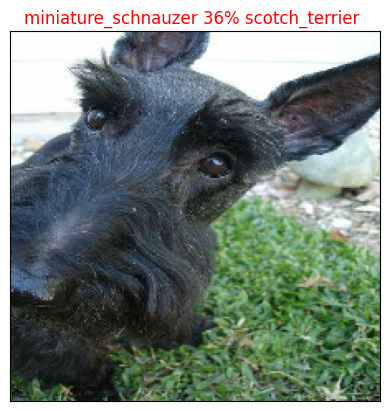

In [47]:
plot_pred(predictions,val_labels,val_images)

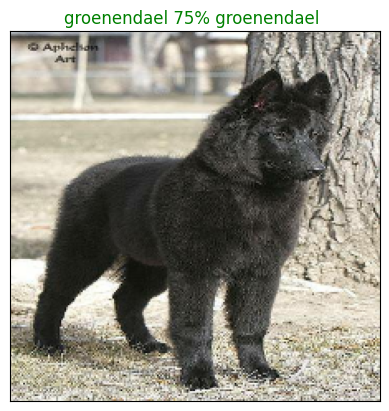

In [48]:
plot_pred(predictions,val_labels,val_images,45)

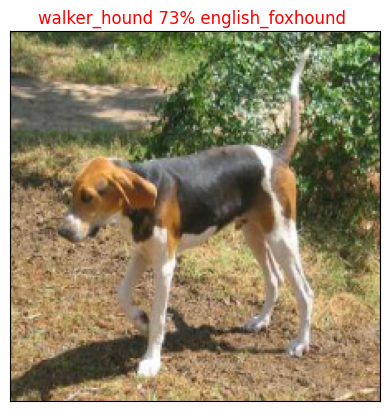

In [49]:
plot_pred(predictions,val_labels,val_images,42)

In [50]:
def plot_pred_conf(prediction_probabilities,labels,n=1):
    """
    Plots the top 10 highest prediction confidences along with
    the truth label for sample n.
    """
    pred_prob,true_label=prediction_probabilities[n],labels[n]
    pred_label=get_pred_label(pred_prob)
    top_10_pred_indexes=pred_prob.argsort()[-10:][::-1]
    top_10_pred_values=pred_prob[top_10_pred_indexes]
    top_10_pred_labels=unique_breeds[top_10_pred_indexes]
    top_plot=plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="orange")
    plt.xticks(np.arange(len(top_10_pred_labels)),
               labels=top_10_pred_labels,
               rotation="vertical")
    if np.isin(true_label,top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels==true_label)].set_color("green")
    else:
        pass

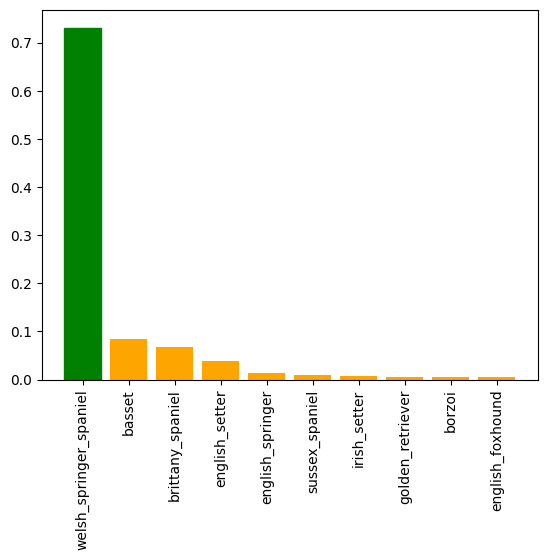

In [51]:
plot_pred_conf(predictions,val_labels,n=36)

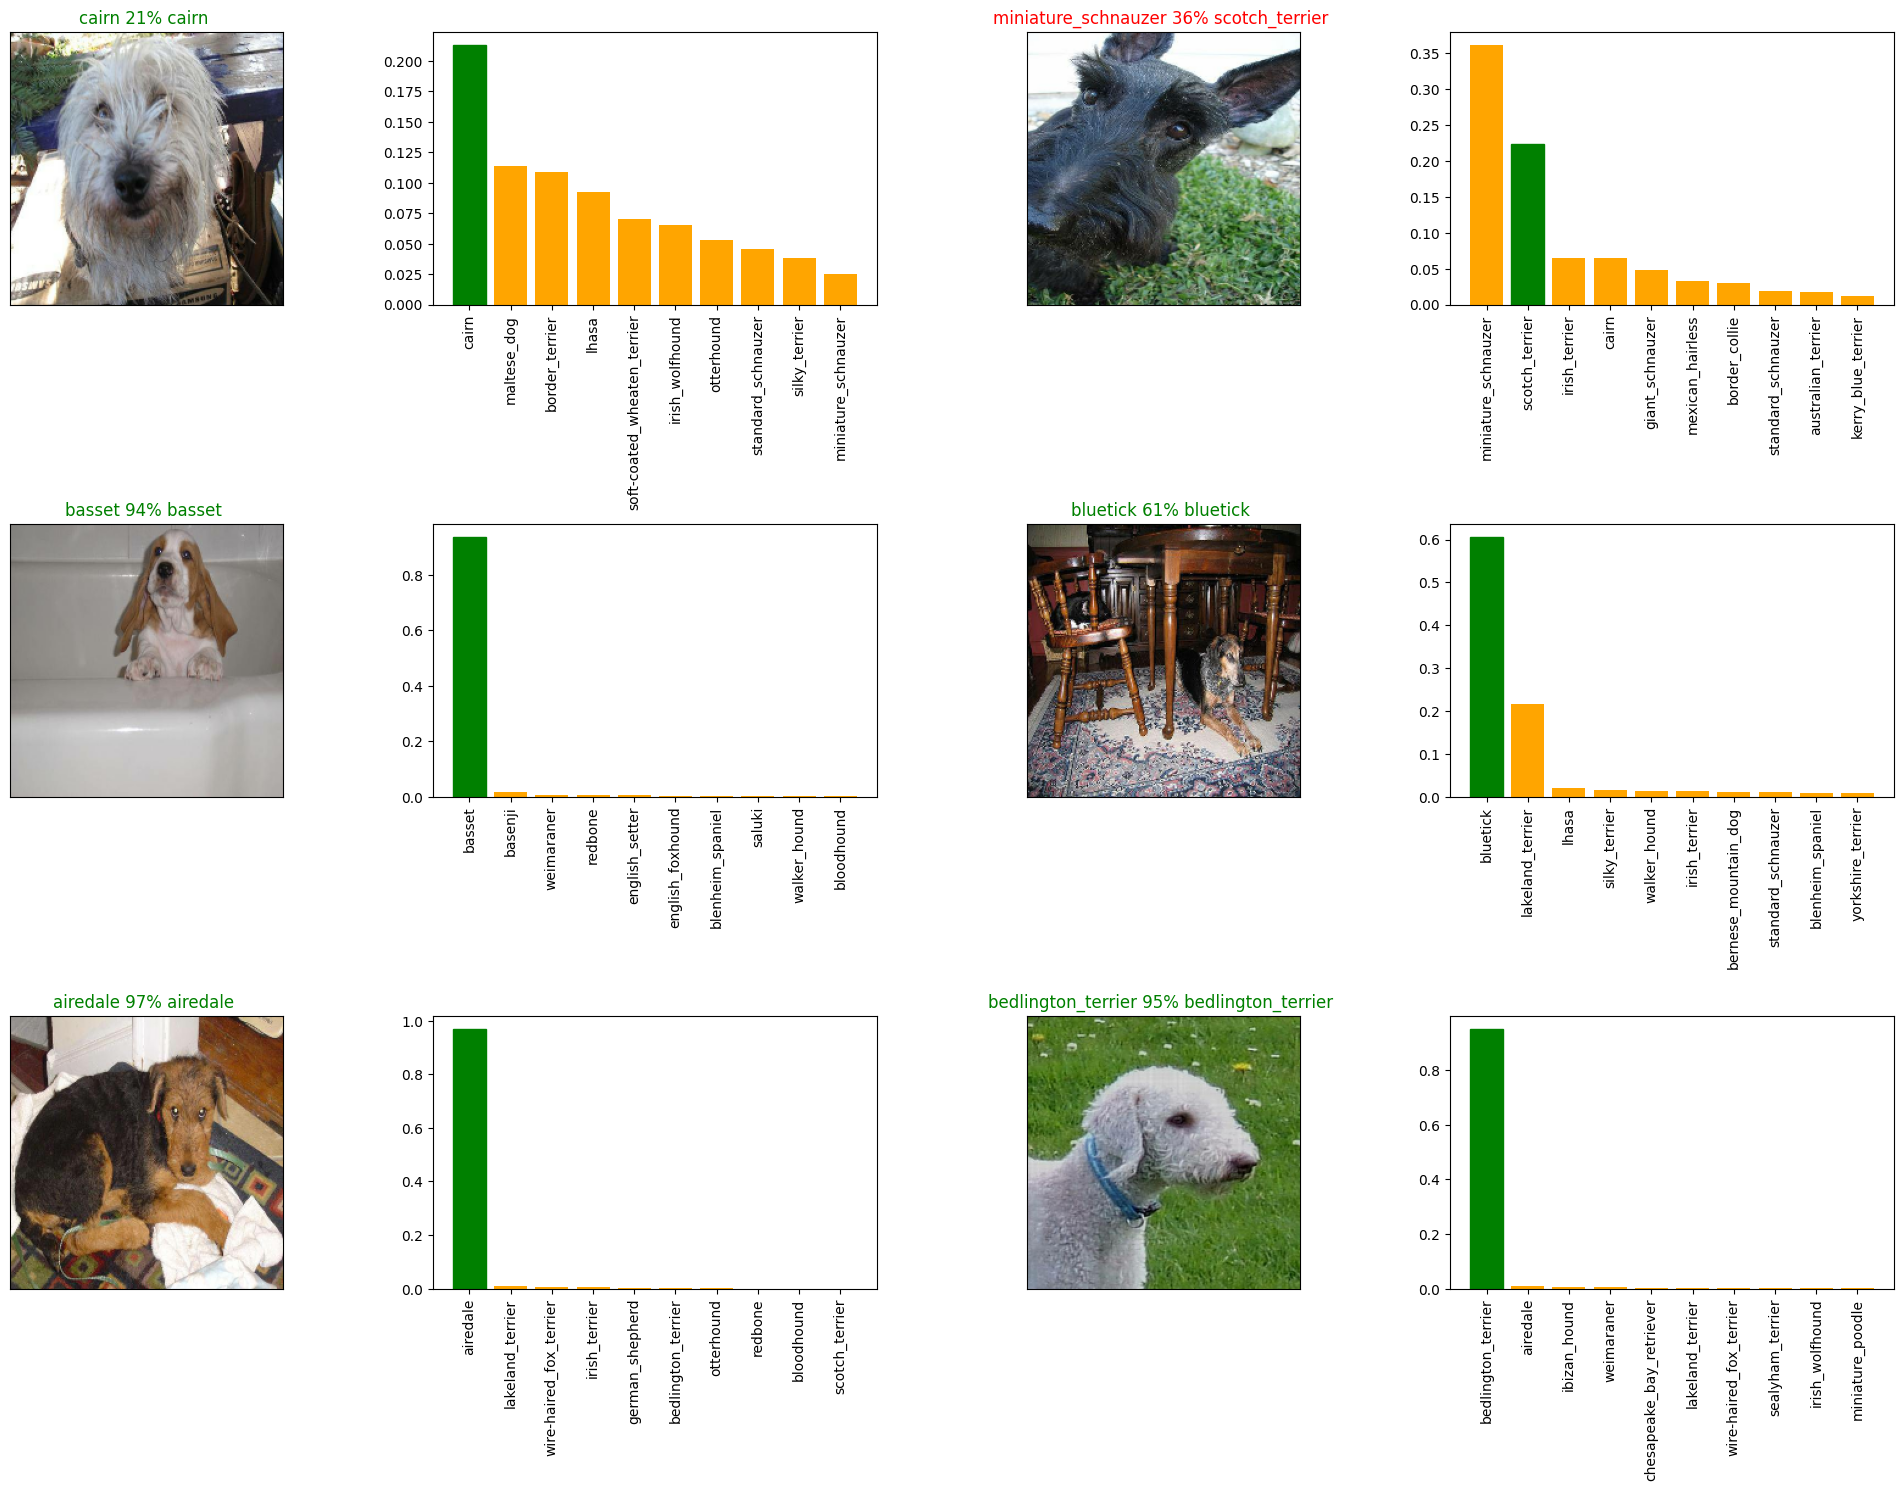

In [57]:
i_multiplier=0;
num_rows=3;
num_col=2;
num_images=num_rows*num_col
plt.figure(figsize=(5*2*num_col, 5*num_rows))
for i in range (num_images):
    plt.subplot(num_rows,2*num_col,2*i+1)
    plot_pred(predictions,val_labels,val_images,i+i_multiplier)
    plt.subplot(num_rows,2*num_col,2*i+2)
    plot_pred_conf(predictions,val_labels,i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## Save and Load the Model

In [60]:
def save_model(model,suffix=None):
    modeldir=os.path.join("drive/folders/1n1jWM3LIA6dTX_mPFRwuQHpo6SeYwMxD",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    model_path=modeldir+"-"+suffix+".h5"
    print(f"Saving model to {model_path}.")
    model.save(model_path)
    return model_path

In [61]:
def load_model(model_path):
    print(f"Loading Model from {model_path}.")
    model=tf.keras.models.load_model(model_path,custom_objects={"KerasLayer":hub.KerasLayer})
    return model

In [62]:
save_model(model,"1000-images-MobileNetv2-Adam")

Saving model to drive/folders/1n1jWM3LIA6dTX_mPFRwuQHpo6SeYwMxD/20240730-125409-1000-images-MobileNetv2-Adam.h5.


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'drive/folders/1n1jWM3LIA6dTX_mPFRwuQHpo6SeYwMxD/20240730-125409-1000-images-MobileNetv2-Adam.h5'

In [63]:
load_1000_image_model=load_model("drive/folders/1n1jWM3LIA6dTX_mPFRwuQHpo6SeYwMxD/20240730-125409-1000-images-MobileNetv2-Adam.h5")

Loading Model from drive/folders/1n1jWM3LIA6dTX_mPFRwuQHpo6SeYwMxD/20240730-125409-1000-images-MobileNetv2-Adam.h5.


## Evaluate the Model

In [64]:
model.evaluate(val_data)

7/7 [==============================] - 0s 48ms/step - loss: 1.3181 - accuracy: 0.6450


[1.3180766105651855, 0.6449999809265137]

In [65]:
load_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 46ms/step - loss: 1.3181 - accuracy: 0.6450


[1.3180766105651855, 0.6449999809265137]

In [66]:
#Training model on entire dataset
len(x),len(y)

(10222, 10222)

In [67]:
len(x_train)

800

In [68]:
full_data=create_data_batches(x,y)

Creating Training Batch


In [69]:
full_model=create_model()

Building Model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [70]:
full_model_tensorboard=create_tensorboard_callback()
full_model_early_stopping=tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience=3)

In [71]:
full_model.fit(full_data,epochs=NUM_EPOCHS,callbacks=[full_model_tensorboard,full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 28s 74ms/step - loss: 1.3679 - accuracy: 0.6574
Epoch 2/100
320/320 [==============================] - 15s 47ms/step - loss: 0.3967 - accuracy: 0.8820
Epoch 3/100
320/320 [==============================] - 15s 46ms/step - loss: 0.2361 - accuracy: 0.9363
Epoch 4/100
320/320 [==============================] - 15s 46ms/step - loss: 0.1555 - accuracy: 0.9628
Epoch 5/100
320/320 [==============================] - 15s 46ms/step - loss: 0.1045 - accuracy: 0.9805
Epoch 6/100
320/320 [==============================] - 15s 46ms/step - loss: 0.0772 - accuracy: 0.9847
Epoch 7/100
320/320 [==============================] - 15s 46ms/step - loss: 0.0584 - accuracy: 0.9914
Epoch 8/100
320/320 [==============================] - 15s 46ms/step - loss: 0.0457 - accuracy: 0.9942
Epoch 9/100
320/320 [==============================] - 15s 46ms/step - loss: 0.0371 - accuracy: 0.9959
Epoch 10/100
320/320 [==============================] - 15s 46ms/step - l

In [72]:
save_model(model,"full-data-MobileNetv2-Adam")

Saving model to drive/folders/1n1jWM3LIA6dTX_mPFRwuQHpo6SeYwMxD/20240730-132308-full-data-MobileNetv2-Adam.h5.


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'drive/folders/1n1jWM3LIA6dTX_mPFRwuQHpo6SeYwMxD/20240730-132308-full-data-MobileNetv2-Adam.h5'

In [73]:
loaded_full_model=load_model("drive/folders/1n1jWM3LIA6dTX_mPFRwuQHpo6SeYwMxD/20240730-132308-full-data-MobileNetv2-Adam.h5")

Loading Model from drive/folders/1n1jWM3LIA6dTX_mPFRwuQHpo6SeYwMxD/20240730-132308-full-data-MobileNetv2-Adam.h5.


# Making Predictions on Test Images

In [77]:
test_path="/kaggle/input/dog-breed-identification/test/"
test_filenames=[test_path+fname for fname in os.listdir(test_path)]
test_filenames[:10]

['/kaggle/input/dog-breed-identification/test/09e51e17e2b756ff2ace8a87bd1443fa.jpg',
 '/kaggle/input/dog-breed-identification/test/f7a32505c12649183c5991ecfa7d68b3.jpg',
 '/kaggle/input/dog-breed-identification/test/bc6d50ffb4644feb34530aa58943e85b.jpg',
 '/kaggle/input/dog-breed-identification/test/7cbc041e79135a572aad87904b5c9c57.jpg',
 '/kaggle/input/dog-breed-identification/test/f3b603f10d6a344f0395fb46b242ff8e.jpg',
 '/kaggle/input/dog-breed-identification/test/db55098d859d27a3c05b0e3fc41d43e7.jpg',
 '/kaggle/input/dog-breed-identification/test/665bab06a3ea861c0812c778486988e3.jpg',
 '/kaggle/input/dog-breed-identification/test/7b57911ea7559cebd6db308125926642.jpg',
 '/kaggle/input/dog-breed-identification/test/df0d6ba158287cb2b3ed6459a22d42ba.jpg',
 '/kaggle/input/dog-breed-identification/test/b80d89ad4a17ac2537ff46d251efcd7c.jpg']

In [78]:
len(test_filenames)

10357

In [83]:
test_data=create_data_batches(test_filenames,test_data=True)

Creating Test Batches


In [84]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [85]:
test_predictions=loaded_full_model.predict(test_data,verbose=1)

324/324 [==============================] - 26s 80ms/step


In [86]:
test_predictions[:10]

array([[3.0517796e-04, 1.2413904e-05, 1.0932103e-02, ..., 1.0506682e-03,
        7.6176344e-05, 1.3288095e-03],
       [6.9597473e-07, 1.2590132e-05, 6.7047893e-07, ..., 1.4809201e-05,
        7.4102982e-06, 1.4738866e-05],
       [2.0671991e-04, 6.4020552e-02, 1.2211133e-04, ..., 1.9531917e-04,
        4.8482103e-05, 4.1133906e-05],
       ...,
       [6.3889177e-04, 1.3826732e-03, 5.0243852e-05, ..., 4.4018791e-05,
        6.3316097e-06, 2.1287922e-05],
       [1.0492102e-02, 5.6896906e-04, 5.7472911e-04, ..., 1.8796207e-03,
        1.3164879e-04, 3.8369774e-04],
       [2.1192647e-04, 1.7730296e-03, 9.5462376e-05, ..., 1.0022004e-03,
        1.3557449e-04, 4.1456468e-04]], dtype=float32)

In [88]:
test_predictions.shape

(10357, 120)

In [102]:
preds_df=pd.DataFrame(columns=["id"]+list(unique_breeds))

In [91]:
test_ids=[os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"]=test_ids

In [92]:
preds_df.head()

id affenpinscher afghan_hound  \
0  09e51e17e2b756ff2ace8a87bd1443fa           NaN          NaN   
1  f7a32505c12649183c5991ecfa7d68b3           NaN          NaN   
2  bc6d50ffb4644feb34530aa58943e85b           NaN          NaN   
3  7cbc041e79135a572aad87904b5c9c57           NaN          NaN   
4  f3b603f10d6a344f0395fb46b242ff8e           NaN          NaN   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 NaN      NaN                            NaN         NaN   
1                 NaN      NaN                            NaN         NaN   
2                 NaN      NaN                            NaN         NaN   
3                 NaN      NaN                            NaN         NaN   
4                 NaN      NaN                            NaN         NaN   

  australian_terrier basenji basset  ... toy_poodle toy_terrier vizsla  \
0                NaN     NaN    NaN  ...        NaN         NaN    NaN   
1                NaN     NaN    NaN  ...        NaN         NaN    NaN   
2                NaN     NaN    NaN  ...        NaN         NaN    NaN   
3                NaN     NaN    NaN  ...        NaN         NaN    NaN   
4                NaN     NaN    NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   
2          NaN        NaN                    NaN                         NaN   
3          NaN        NaN                    NaN                         NaN   
4          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  
2     NaN                     NaN               NaN  
3     NaN                     NaN               NaN  
4     NaN                     NaN               NaN  

[5 rows x 121 columns]

In [93]:
preds_df[list(unique_breeds)]=test_predictions

In [94]:
preds_df.head()

id  affenpinscher  afghan_hound  \
0  09e51e17e2b756ff2ace8a87bd1443fa   3.051780e-04      0.000012   
1  f7a32505c12649183c5991ecfa7d68b3   6.959747e-07      0.000013   
2  bc6d50ffb4644feb34530aa58943e85b   2.067199e-04      0.064021   
3  7cbc041e79135a572aad87904b5c9c57   5.720073e-04      0.000029   
4  f3b603f10d6a344f0395fb46b242ff8e   2.380580e-06      0.000012   

   african_hunting_dog  airedale  american_staffordshire_terrier  appenzeller  \
0         1.093210e-02  0.000304                    2.992426e-01     0.000809   
1         6.704789e-07  0.000007                    6.597103e-07     0.000067   
2         1.221113e-04  0.002220                    2.704651e-04     0.000438   
3         4.859022e-04  0.000303                    1.301106e-02     0.000203   
4         2.246934e-06  0.000012                    6.072083e-06     0.000003   

   australian_terrier   basenji    basset  ...  toy_poodle   toy_terrier  \
0        6.295817e-04  0.252049  0.000559  ...    0.000496  4.904544e-03   
1        4.401572e-07  0.000027  0.000111  ...    0.000001  1.983539e-07   
2        8.945370e-04  0.000130  0.000104  ...    0.000514  1.091584e-05   
3        1.139223e-03  0.001170  0.000183  ...    0.000297  6.567162e-04   
4        2.738309e-06  0.000003  0.000303  ...    0.000004  3.110549e-06   

     vizsla  walker_hound  weimaraner  welsh_springer_spaniel  \
0  0.001337      0.003775    0.000693            6.134821e-05   
1  0.000047      0.000019    0.000022            4.011578e-07   
2  0.000087      0.000281    0.000256            2.872324e-04   
3  0.003684      0.000819    0.005241            2.728135e-04   
4  0.000012      0.000032    0.000005            9.960819e-01   

   west_highland_white_terrier   whippet  wire-haired_fox_terrier  \
0                 7.064227e-04  0.001051                 0.000076   
1                 2.248095e-07  0.000015                 0.000007   
2                 8.991080e-05  0.000195                 0.000048   
3                 1.833982e-05  0.023620                 0.003533   
4                 3.207089e-06  0.000002                 0.000045   

   yorkshire_terrier  
0           0.001329  
1           0.000015  
2           0.000041  
3           0.000080  
4           0.000002  

[5 rows x 121 columns]

In [98]:
preds_df.to_csv("/kaggle/working/drive/model_predictions_submission-1.csv",index=False)

In [99]:
ans=pd.read_csv("/kaggle/working/drive/model_predictions_submission-1.csv")

In [100]:
ans.head()

id  affenpinscher  afghan_hound  \
0  09e51e17e2b756ff2ace8a87bd1443fa   3.051780e-04      0.000012   
1  f7a32505c12649183c5991ecfa7d68b3   6.959747e-07      0.000013   
2  bc6d50ffb4644feb34530aa58943e85b   2.067199e-04      0.064021   
3  7cbc041e79135a572aad87904b5c9c57   5.720073e-04      0.000029   
4  f3b603f10d6a344f0395fb46b242ff8e   2.380580e-06      0.000012   

   african_hunting_dog  airedale  american_staffordshire_terrier  appenzeller  \
0         1.093210e-02  0.000304                    2.992426e-01     0.000809   
1         6.704789e-07  0.000007                    6.597103e-07     0.000067   
2         1.221113e-04  0.002220                    2.704651e-04     0.000438   
3         4.859022e-04  0.000303                    1.301106e-02     0.000203   
4         2.246934e-06  0.000012                    6.072083e-06     0.000003   

   australian_terrier   basenji    basset  ...  toy_poodle   toy_terrier  \
0        6.295817e-04  0.252049  0.000559  ...    0.000496  4.904544e-03   
1        4.401572e-07  0.000027  0.000111  ...    0.000001  1.983539e-07   
2        8.945370e-04  0.000130  0.000104  ...    0.000514  1.091584e-05   
3        1.139223e-03  0.001170  0.000183  ...    0.000297  6.567162e-04   
4        2.738309e-06  0.000003  0.000303  ...    0.000004  3.110549e-06   

     vizsla  walker_hound  weimaraner  welsh_springer_spaniel  \
0  0.001337      0.003775    0.000693            6.134821e-05   
1  0.000047      0.000019    0.000022            4.011578e-07   
2  0.000087      0.000281    0.000256            2.872324e-04   
3  0.003684      0.000819    0.005241            2.728135e-04   
4  0.000012      0.000032    0.000005            9.960819e-01   

   west_highland_white_terrier   whippet  wire-haired_fox_terrier  \
0                 7.064227e-04  0.001051                 0.000076   
1                 2.248095e-07  0.000015                 0.000007   
2                 8.991080e-05  0.000195                 0.000048   
3                 1.833982e-05  0.023620                 0.003533   
4                 3.207089e-06  0.000002                 0.000045   

   yorkshire_terrier  
0           0.001329  
1           0.000015  
2           0.000041  
3           0.000080  
4           0.000002  

[5 rows x 121 columns]